In [1]:
import numpy as np 
import MLP.MLP_module as mlp
import os
import pandas as pd

os.chdir('../')

from cosmology_functions.zmax import RedshiftGW_fast_zmax
from gw_functions.mass_priors import MassPrior_sample
from cosmology_functions import priors, cosmology, utilities
from gw_functions import gw_priors_v2


run = 'O4'
zmin = 0.000001
zmax = 5
name_population_model = 'BBH'
mass_distribution = 'PowerLaw+Peak'
population = 'BBH'

population_parameters = {
    'beta': 0.81,                # Power-law index for mass distribution
    'alpha': 3.78,               # Power-law index for redshift evolution
    'mmin': 4.98,                # Minimum mass of compact objects (solar masses)
    'mmax': 112.5,               # Maximum mass of compact objects (solar masses)
    'mu_g': 32.27,               # Mean of Gaussian component in mass distribution (solar masses)
    'sigma_g': 3.88,             # Standard deviation of Gaussian component in mass distribution
    'lambda_peak': 0.03,         # Fraction of Gaussian component in mass distribution
    'delta_m': 4.8,              # Sharpness of the mass cutoff in the distribution
    'name': 'BBH-powerlaw-gaussian',  # Name of the population model (BBH or NSBH)
    'population': population,    # Type of population ('BBH' or 'NSBH')
    'gamma': 4.59,               # Parameter for rate evolution with redshift
    'k': 2.86,                   # Parameter for luminosity evolution
    'zp': 2.47,                  # Redshift at which the rate evolution changes slope
    'lam': 0,                    # Lambda parameter (related to cosmology)
    'Om': 0.305,                 # Omega_matter, a cosmological parameter (density of matter in the universe)
    'zmax': zmax                 # Maximum redshift for the simulation
}

# Initialize the RedshiftGW_fast_zmax class, which calculates the maximum redshift for gravitational wave events.
# This class will use the population parameters and the specified redshift range to compute various metrics.
zmax_class = RedshiftGW_fast_zmax(
    parameters=population_parameters,  # Pass the population parameters
    run=run,                           # Specify the detector run (O1, O2, etc.)
    zmin=zmin,                         # Minimum redshift considered in the simulation
    zmax=zmax                          # Maximum redshift considered in the simulation
)
# Print the value of the magic SNR x DL, a constant used in calculating signal-to-noise ratios for GW detections.
print(f"Magic SNRxDL = {zmax_class.magic_snr_dl}")

# Initialize the MassPrior_sample class, which samples masses for gravitational wave events
# based on the specified mass distribution (e.g., PowerLaw+Peak, Uniform).
# This class will generate the masses for the simulated events.
mass_class = MassPrior_sample(population_parameters, mass_distribution)
print(f"Mass prior class initialized for {mass_distribution} distribution.")


### Sample m1 and m2
# snrs = mlp.load_and_predict(testing_data, model_dir='models/MLP_models/O4_SNR_approx_HLV', device='cuda:0')

/home/federico/.conda/envs/cosmoflow_v1/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Magic SNRxDL = 90000
Mass prior class initialized for PowerLaw+Peak distribution.


In [119]:
from scipy.stats import ncx2
import time
import sys
import warnings
# Suppress warnings
warnings.filterwarnings('ignore')

# Hubble constant and other parameters
H0 = 70  # Hubble constant
SNRth = 11  # SnR threshold
N = 10000  # Samples
Nfinal = 5000
final_data = pd.DataFrame()

def chirp_func(m1,m2):
    return (m1*m2)**(3/5) / (m1+m2)**(1/5)
    
def Mz_min(Dl, mmin):
    mz = (0.0044*Dl)**(6/5) - mmin/ (2**(1/5))
    mz[mz<chirp_func(mmin,mmin)] = mmin / (2**(1/5))
    return mz

start = time.time()
while True:
    # Compute the maximum redshift (zmax) for each H0 value based on the SNR threshold (SNRth)
    zmax_samples = zmax_class.zmax_H0(H0, SNRth)
    # Generate cumulative distribution functions (cdfs) from the zmax samples using multiprocessing
    cdfs_zmax = zmax_class.make_cdfs(zmax_samples)

    # Sample redshifts based on zmax-H0 distributions for each missed H0
    z = zmax_class.draw_z_zmax(N, [cdfs_zmax])
    # Convert redshifts and H0 values into luminosity distances
    dl = cosmology.fast_z_to_dl_v2(np.array(z), np.array(H0))

    # Sample RA and Dec coordinates
    RA, dec = cosmology.draw_RA_Dec(N)

    ############# GW Intrinsic parameters #####################################
    # Sample priors on gravitational wave parameters
    # theta_jn (inclination angle), psi (polarization angle), geo_time (geocentric time) are some of the sampled parameters
    _, _, _, a1, a2, tilt1, tilt2, _, _, theta_jn, phi_jl, phi_12, psi, _, geo_time = gw_priors_v2.draw_prior(N)


    # ################## Original m1,m2
    # # Sample primary (m1) and secondary (m2) masses for the gravitational wave events
    # m1, m2 = mass_class.PL_PEAK_GWCOSMO(N)  # Sample primary and secondary masses based on GWCOSMO mass prior



    ################################## FAST mz-Dl
    # Calculate the minimum redshifted chirp mass for each luminosity distance
    mz_min = Mz_min(dl, mmin = population_parameters['mmin'])

    # Initialize lists to store valid samples
    m1, m2 = [], []

    # Loop until we have enough valid chirp masses
    while len(m1) < N:
        # Sample primary (m1) and secondary (m2) masses for the gravitational wave events
        m1_test, m2_test = mass_class.PL_PEAK_GWCOSMO(N)  # Sample primary and secondary masses based on GWCOSMO mass prior

        # Calculate the chirp mass and redshifted chirp mass
        chirp_mass = chirp_func(m1_test, m2_test)
        redshifted_chirp_mass = chirp_mass * (1 + z)

        # Check if redshifted chirp mass is above the minimum threshold
        valid_chirp_mass_indices = redshifted_chirp_mass >= mz_min

        # Store only the valid samples
        m1.extend(m1_test[valid_chirp_mass_indices])
        m2.extend(m2_test[valid_chirp_mass_indices])

    # Trim the lists to have exactly N samples
    m1 = np.array(m1[:N])
    m2 = np.array(m2[:N])

    

    # Create a DataFrame to hold all the sampled GW parameters
    GWdata_testing = pd.DataFrame({
        'mass_1': m1,
        'mass_2': m2,
        'a_1': a1,
        'a_2': a2,
        'tilt_1': tilt1,
        'tilt_2': tilt2,
        'ra': RA,
        'dec': dec,
        'theta_jn': theta_jn,
        'phi_jl': phi_jl,
        'phi_12': phi_12,
        'psi': psi,
        'geocent_time': geo_time % 86164.0905,
    })

    # Load and predict SNR values for the gravitational wave parameters
    snrs = mlp.load_and_predict(GWdata_testing, model_dir='make_scripts/models/MLP_models/O4_SNR_approx_HLV', device='cuda:0')
    # Calculate SNR values for each detector
    snrs_pred = snrs / dl[:, np.newaxis]
    snr_H1 = snrs_pred[:, 0]
    snr_L1 = snrs_pred[:, 1]
    snr_V1 = snrs_pred[:, 2]
    # Calculate the network SNR
    snr_network = np.sqrt(snr_H1**2 + snr_L1**2 + snr_V1**2)

    # Select only the samples that have network SNR above the threshold
    valid_indices = snr_network > SNRth
    if np.sum(valid_indices) == 0:
        # print("No samples with sufficient SNR, repeating iteration...")
        continue

    # Filter the data to include only samples with SNR above the threshold
    GWdata_filtered = GWdata_testing[valid_indices]
    dl_filtered = dl[valid_indices]
    snr_network_filtered = snr_network[valid_indices]
    z_filtered = z[valid_indices]
    # Sample matched filter SNR from non-central chi-squared distribution
    # Use the network SNR as the non-centrality parameter for the chi-squared distribution
    dof = 3  # Degrees of freedom for a standard matched-filtering scenario
    snr_matched_filter = np.sqrt(ncx2.rvs(dof, snr_network_filtered**2))

    # Append the filtered data to the final dataset
    filtered_data = GWdata_filtered.copy()
    filtered_data['luminosity_distance'] = dl_filtered
    filtered_data['z'] = z_filtered
    filtered_data['matched_filter_SNR'] = snr_matched_filter
    
    final_data = pd.concat([final_data, filtered_data], ignore_index=True)
    # Output the number of GW events deemed detectable (above threshold)
    sys.stdout.write("\rNumber of detectable GW events found: {}".format(len(final_data)))
    sys.stdout.flush()
    if len(final_data) >= Nfinal:
        break
end = time.time()
print()
print('Time: {} s'.format(end - start))

Number of detectable GW events found: 5073
Time: 16.053799867630005 s


In [123]:
# Given sample data
# samples = [15.15, 16.12, 15.76, 16.15, 16.053]
samples = [22.2, 21.94, 22.67, 20.08]
# Convert to numpy array
data = np.array(samples)
# Calculate statistics
mean = np.mean(data)
std_dev = np.std(data)

# Print statistics
print(f"Mean: {mean:.2f}")
print(f"Standard Deviation: {std_dev:.2f}")

Mean: 21.72
Standard Deviation: 0.98


In [106]:
final_data.head()

,mass_1,mass_2,a_1,a_2,tilt_1,tilt_2,ra,dec,theta_jn,phi_jl,phi_12,psi,geocent_time,luminosity_distance,z,matched_filter_SNR
0,38.824476,28.617235,0.044939,0.089845,1.685046,1.919028,4.160716,0.661226,1.110260,4.075803,0.162004,1.734896,67204.643715,1416.814706,0.277272,15.418087
1,58.458839,28.438701,0.624767,0.474519,2.318105,1.156522,1.793870,0.067613,2.631213,5.833000,5.887390,1.500415,19939.112048,2589.291029,0.464431,12.326615
2,32.968461,31.798825,0.420060,0.987565,2.246990,1.693820,5.754141,-0.820701,2.412082,1.711653,5.324875,2.323922,34001.215633,3411.080996,0.584205,10.434496
3,34.664009,31.379929,0.267706,0.676269,1.169102,1.415526,6.241091,0.581172,2.887106,1.428564,0.943338,0.354092,70594.710953,2972.360872,0.521175,12.632556
4,11.969801,8.914526,0.873181,0.533208,1.872131,1.614498,3.636182,0.242475,0.180728,3.170892,0.057967,0.077880,66599.942175,722.569411,0.151883,16.444421


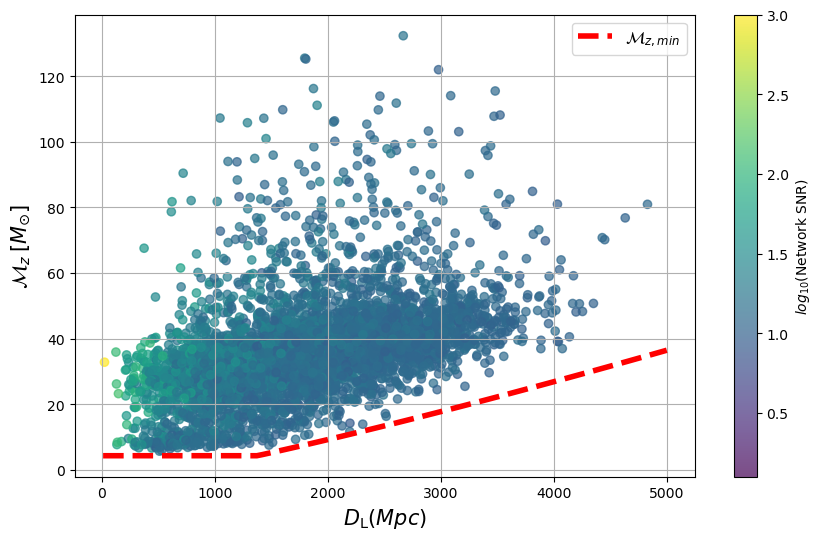

In [107]:
# Calculate the redshifted chirp mass
def chirp_func(m1,m2):
    return (m1*m2)**(3/5) / (m1+m2)**(1/5)
    
def Mz_min(Dl, mmin):
    mz = (0.0044*Dl)**(6/5) - mmin/ (2**(1/5))
    mz[mz<chirp_func(mmin,mmin)] = mmin / (2**(1/5))
    return mz

chirp_mass = chirp_func(final_data.mass_1, final_data.mass_2) 
redshifted_chirp_mass = chirp_mass * (1 + final_data.z)

# Scatter plot with luminosity distance (dl) on x-axis, redshifted chirp mass on y-axis, and color as SNR
plt.figure(figsize=(10, 6))

plt.plot(np.linspace(10,5000, 100), Mz_min(np.linspace(10,5000, 100), mmin = population_parameters['mmin']), '--r', linewidth =4, label = r'$\mathcal{M}_{z,min}$')

sc = plt.scatter(final_data.luminosity_distance, redshifted_chirp_mass, c=np.log10(final_data.matched_filter_SNR), cmap='viridis', alpha=0.7, vmin = 0.1, vmax = 3)
plt.colorbar(sc, label=r'$log_{10}$(Network SNR)')
plt.xlabel(r'$D_{\text{L}} (Mpc)$',fontsize = 15)
plt.ylabel(r'$\mathcal{M}_{z} \: [M_{\odot}]$', fontsize = 15)
plt.legend(fontsize = 12)
plt.grid(True)
plt.show()